#### Needed Libraries 

In [33]:
###system 
import sys


###loading and saving data
import pickle
import dill
import datetime


###bases
import numpy as np

import copy

#preprocessing 
from sklearn.preprocessing import StandardScaler



#### Loading all the dataset

In [34]:
file= open("/Users/lakrama/Neuro Project Codes/Datasets/Data_Sets/Synthetic Data/Uncentered X/Bounded_Var_Time:2024-04-15 19:35:40, intercept:5,n_train:5000, n_test:1000, tensor_dimensions:[32 32], tensor_mode_ranks:[4 4], separation_rank:2.pkl", 'rb')
data = pickle.load(file)
file.close()

X_train_Full = data[0]
print(data[0].shape)

Y_train_Full = data[1]
print(data[1].shape)

X_test_Full = data[2]
print(data[2].shape)

Y_test_Full = data[3]
print(data[3].shape)

B_tensored = data[4]
print(data[4].shape)

G1 = data[5]
print(data[5].shape)

all_factormatrices = data[6]
#print(data[6].shape)

Y_train_nonoise = data[7]
print(data[7].shape)

#all the factor matrices 
B_1_1 = all_factormatrices[0][0]
print(f'factor matrix 1_1:{B_1_1.shape}')
B_1_2 = all_factormatrices[0][1]
print(f'factor matrix 1_1:{B_1_2.shape}')
B_2_1 = all_factormatrices[1][0]
print(f'factor matrix 1_1:{B_2_1.shape}')
B_2_2 = all_factormatrices[0][0]
print(f'factor matrix 1_1:{B_2_2.shape}')


(5000, 32, 32)
(5000,)
(1000, 32, 32)
(1000,)
(32, 32)
(4, 4)
(6000,)
factor matrix 1_1:(32, 4)
factor matrix 1_1:(32, 4)
factor matrix 1_1:(32, 4)
factor matrix 1_1:(32, 4)


#### All Needed Scripts 

##### LSR Tensor Object

In [35]:
# Low Separation Rank Tensor Decomposition
class LSR_tensor_dot():
    # Constructor
    def __init__(self, shape, ranks, separation_rank, dtype = np.float32, intercept = False ,initialize = True):
        super(LSR_tensor_dot, self).__init__()
        self.shape = shape
        self.ranks = ranks
        self.separation_rank = separation_rank
        self.dtype = dtype
        self.order = len(shape)
        self.init_params(initialize)
        self.init_params(intercept)

    # Initialize Parameters
    def init_params(self, intercept = False ,initialize = True):
        # Initialize core tensor as independent standard gaussians
        if not initialize:
            self.core_tensor = np.zeros(shape = self.ranks)
        else:
            self.core_tensor = np.random.normal(size = self.ranks)

        # Set up Factor Matrices
        self.factor_matrices = []

        # Initialize all factor matrices
        for s in range(self.separation_rank):
            factors_s = []
            for k in range(self.order):
                if not initialize:
                    factor_matrix_B = np.eye(self.shape[k])[:, self.ranks[k]]
                    factors_s.append(factor_matrix_B)
                else:
                    factor_matrix_A = np.random.normal(0,1,size= (self.shape[k], self.ranks[k]))
                    factors_s.append(factor_matrix_A)

            self.factor_matrices.append(factors_s)

        if intercept:
          ('intercept is initialized')
          self.b = np. random.normal(0,1)
        else:
          (print('intercept is not initialized'))
          self.b = 0

    # Expand core tensor and factor matrices to full tensor, optionally excluding
    # a given term from the separation rank decomposition
    def expand_to_tensor(self, skip_term = None):
        full_lsr_tensor = np.zeros(shape = self.shape)

        #Calculate Expanded Tensor
        for s, term_s_factors in enumerate(self.factor_matrices):
            if s == skip_term: continue
            expanded_tucker_term = term_s_factors[0] @ self.core_tensor @ term_s_factors[1].T
            full_lsr_tensor += expanded_tucker_term

        #Column Wise Flatten full_lsr_tensor
        full_lsr_tensor = full_lsr_tensor.flatten(order = 'F')
        return full_lsr_tensor

    # Absorb all factor matrices and core tensor into the input tensor except for matrix s, k
    # Used during a factor matrix update step of block coordiante descent
    def bcd_factor_update_x_y(self, s, k, x, y):
        #Take x and swap axes 1 and 2 so that vectorization occurs "COLUMN WISE"
        x_transpose = np.transpose(x, (0, 2, 1))
        x_transpose_vectorized = np.reshape(x_transpose, newshape = (x_transpose.shape[0], -1))

        #if we are unfolding along mode 1, use x. Else, if we are unfolding along mode, use x_transpose
        x_partial_unfold = x if k == 0 else x_transpose

        #If k = 0(skip first factor matrix), we have 2nd factor matrix. If k= 1(skip second factor matrix), we have first factor matrix
        kronecker_term = self.factor_matrices[s][1] if k == 0 else self.factor_matrices[s][0]

        #if k = 0, G^T. Else if k = 1, put G
        core_tensor_term = self.core_tensor.T if k == 0 else self.core_tensor

        omega = x_partial_unfold @ kronecker_term @ core_tensor_term
        omega = np.transpose(omega, (0, 2, 1))
        omega = np.reshape(omega, newshape = (omega.shape[0], -1))

        X_tilde = omega
        y_tilde = y

        if self.separation_rank == 1:
            pass
        else:
            gamma = np.dot(x_transpose_vectorized,self.expand_to_tensor(skip_term = s))
            #gamma = gamma.reshape(-1,1)
            y_tilde = y - gamma

        return X_tilde, y_tilde

    # Absorb all factor matrices the input tensor (not the core tensor)
    # Used during a core tensor update step of block coordiante descent
    def bcd_core_update_x_y(self, x, y):
        #Take x and swap axes 1 and 2 so that vectorization occurs "COLUMN WISE"
        x_transpose = np.transpose(x, (0, 2, 1))
        x_transpose_vectorized = np.reshape(x_transpose, newshape = (x_transpose.shape[0], -1))

        #Calculate y_tilde
        y_tilde = y

        #Calculate Kronecker Factor Sum
        kron_factor_sum = 0
        for term_s_factors in self.factor_matrices:
            kron_factor_sum += np.kron(term_s_factors[1], term_s_factors[0])

        #Return Core Update
        return (kron_factor_sum.T @ x_transpose_vectorized.T).T, y_tilde


    #Retrieve factor matrix
    def get_factor_matrix(self, s, k):
      return self.factor_matrices[s][k]

    #Update factor matrix
    def update_factor_matrix(self, s, k, updated_factor_matrix: np.ndarray):
      self.factor_matrices[s][k] = updated_factor_matrix

    def update_intercept(self,updated_b):
      self.b = updated_b

    #Retrieve Core Matrix
    def get_core_matrix(self):
      return self.core_tensor

    #Update core matrix
    def update_core_matrix(self, updated_core_matrix: np.ndarray):
      self.core_tensor = updated_core_matrix

    #Retrive intercept
    def get_intercept(self):
      return self.b

#### BCD Regression

In [36]:
#lsr_ten: LSR Tensor
#training_data: X
#training_labels: Y
#hypers: hyperparameters
def lsr_bcd_regression(lsr_ten, training_data: np.ndarray, training_labels: np.ndarray, hypers: dict,intercept = False, Initializer = None):
    #Get LSR Tensor Information and other hyperparameters
    shape, ranks, sep_rank, order = lsr_ten.shape, lsr_ten.ranks, lsr_ten.separation_rank, lsr_ten.order
    lambda1 = hypers["weight_decay"]
    max_iter = hypers["max_iter"]
    threshold = hypers["threshold"]
    lr        = hypers["learning_rate"]
    epochs    = hypers["epochs"]
    batch_size = hypers["batch_size"]
    decay_factor = hypers["decay_factor"]
    b_intercept = intercept

    #Create models for each factor matrix and core matrix
    #factor_matrix_models = [[Ridge(alpha = lambda1, solver = 'svd', fit_intercept = intercept) for k in range(len(ranks))] for s in range(sep_rank)]
    #core_tensor_model = Ridge(alpha = lambda1, solver = 'svd', fit_intercept = intercept)

    #Store objective function values
    objective_function_values = np.ones(shape = (max_iter, sep_rank, len(ranks) + 1)) * np.inf

    X, y = training_data, training_labels
    if intercept: b_start = lsr_ten.get_intercept()
    expanded_lsr_start  = lsr_ten.expand_to_tensor()
    expanded_lsr_start  = np.reshape(expanded_lsr_start, X[0].shape, order = 'F')
    objective_function_value_star = objective_function_tensor_sep(y, X, expanded_lsr_start,lsr_ten, lambda1, b if intercept else None)
    print('Objective Function Value:',objective_function_value_star)

    #Normalized Estimation Error
    iterations_normalized_estimation_error = np.zeros(shape = (max_iter,))
    
    #Gradient Values
    gradient_values = np.ones(shape = (max_iter, sep_rank, len(ranks) + 1)) * np.inf

    #Epoch Level Function Values 
    epoch_level_function_values = np.ones(shape = (max_iter,sep_rank,len(ranks)+1,epochs))*np.inf

    #Epoch Level Gradients
    epoch_gradient_values = np.ones(shape = (max_iter,sep_rank,len(ranks)+1,epochs))*np.inf

    #saving the tensor
    tensor_iteration = []
    #saving iterate-wise data
    factor_core_iterates = []

    #iterate differences 
    iterate_difference = np.ones(shape = (max_iter, sep_rank, len(ranks) + 1)) * np.inf

    #Run at most max_iter iterations of Block Coordinate Descent
    for iteration in range(max_iter):
        #print('')
        print('--------------------------------------------------------------BCD iteration',iteration,'--------------------------------------------------------------')
        factor_residuals = np.zeros(shape = (sep_rank, len(ranks)))
        core_residual = 0

        #Store updates to factor matrices and core tensor
        updated_factor_matrices = np.empty((sep_rank, len(ranks)), dtype=object)
        updated_core_tensor = None

        #Iterate over the Factor Matrices.
        for s in range(sep_rank):
            for k in range(len(ranks)):
                
                #Absorb Factor Matrices into X aside from (s, k) to get X_tilde
                print('---------------------------------------------Sep',s,'Factor',k,'-------------------------------------------------')
                X, y = training_data, training_labels
                X_tilde, y_tilde = lsr_ten.bcd_factor_update_x_y(s, k, X, y) #y tilde should now be y-b-<Q,X>
                

                #Solve the sub-problem pertaining to the factor tensor
                hypers = {'lambda': lambda1, 'lr': lr, 'epochs': epochs, 'batch_size': batch_size, 'bias': b_intercept, 'decay_factor': decay_factor}
                #weights, bias, loss_values, gap_to_optimality, nmse_values, corr_values, R2_values,sub_problem_gradient = SGD(X_tilde, y_tilde.reshape(-1,1), cost_function_code = 1, hypers = hypers , optimizer_code = 0, p_star = 0)
                
                sub_problem_gradient = 0
                loss_values = 0
                bias = 0


                #printing the subproblem gradients
                #print(f"Final gradient of the subproblem {s,k} : {sub_problem_gradient[-1]}")
                epoch_gradient_values[iteration,s,k,:] = sub_problem_gradient
                epoch_level_function_values[iteration,s,k,:] = loss_values

                #Retrieve Original and Updated Factor Matrices
                #Bk = lsr_ten.get_factor_matrix(s, k)
                #Bk1 = weights
                if intercept: b = bias

                #Shape Bk1 as needed
                #Bk1 = np.reshape(Bk1, (shape[k], ranks[k]), order = 'F') #if there is an error check here

                #fixing the factor matrices to be the true value 
                Bk  = all_factormatrices[s][k]
                Bk1 = all_factormatrices[s][k]


                #Update Residuals and store updated factor matrix
                factor_residuals[s][k] = np.linalg.norm(Bk1 - Bk)
                updated_factor_matrices[s, k] = Bk1

                iterate_difference[iteration,s,k] = factor_residuals[s][k]


                #Update Factor Matrix
                lsr_ten.update_factor_matrix(s, k, updated_factor_matrices[s, k])

                #update the intercept
                if intercept: lsr_ten.update_intercept(b)

                #Calculate Objective Function Value
                expanded_lsr = lsr_ten.expand_to_tensor()
                expanded_lsr = np.reshape(expanded_lsr, X[0].shape, order = 'F')
                objective_function_value = objective_function_tensor_sep(y, X, expanded_lsr,lsr_ten,lambda1)
                objective_function_values[iteration, s, k] = objective_function_value

                #Print Objective Function Values
                print(f"Iteration: {iteration}, Separation Rank: {s}, Factor Matrix: {k}, Objective Function Value: {objective_function_value}")
                
                #Calculate Gradient Values
                bk = np.reshape(Bk, (-1, 1), order = 'F') #Flatten Factor Matrix Column Wise
                Omega = X_tilde
                z = bias
                gradient_value = (-2 * Omega.T) @ (y_tilde.reshape(-1,1) - Omega @ bk  - z) + (2 * lambda1 * bk)
                
                #Store Gradient Values
                gradient_values[iteration, s, k] = np.linalg.norm(gradient_value, ord = 'fro')


        #Absorb necessary matrices into X, aside from core tensor, to get X_tilde
        print('---------------------------------------------Core-------------------------------------------------')
        X, y = training_data, training_labels
        X_tilde, y_tilde = lsr_ten.bcd_core_update_x_y(X, y)

        #Solve the sub-problem pertaining to the core tensor
        hypers = {'lambda': lambda1, 'lr': lr, 'epochs': epochs, 'batch_size': batch_size, 'bias': intercept, 'decay_factor':decay_factor}
        weights, bias, loss_values, gap_to_optimality, nmse_values, corr_values, R2_values,sub_problem_gradient,loss_values = SGD(X_tilde, y_tilde.reshape(-1,1), cost_function_code = 1, hypers = hypers, optimizer_code = 0, p_star = 0, Initializer = Initializer)

        print(f"Final gradient of the subproblem Core : {sub_problem_gradient[-1]}")
        epoch_gradient_values[iteration,:,len(ranks),:] = sub_problem_gradient
        epoch_level_function_values[iteration,:,len(ranks),:] = loss_values

        #Get Original and Updated Core Tensor
        Gk = lsr_ten.get_core_matrix()
        Gk1 = np.reshape(weights, ranks, order = 'F')
        b = bias

        #Update Residuals and store updated Core Tensor
        core_residual = np.linalg.norm(Gk1 - Gk)
        updated_core_tensor = Gk1

        #saving iterate differece in a list
        iterate_difference[iteration,:,len(ranks)] = core_residual

        
        #Update Core Tensor
        lsr_ten.update_core_matrix(updated_core_tensor)


        #Update Intercept

        if intercept: lsr_ten.update_intercept(b)

        #Calculate Objective Function Value
        if intercept: b = lsr_ten.get_intercept()
        expanded_lsr = lsr_ten.expand_to_tensor()
        expanded_lsr = np.reshape(expanded_lsr, X[0].shape, order = 'F')

        #saving the lsr tensor 
        tensor_iteration.append(expanded_lsr)

        objective_function_value = objective_function_tensor_sep(y, X, expanded_lsr,lsr_ten, lambda1, b if intercept else None)
        objective_function_values[iteration, :, (len(ranks))] = objective_function_value
        
        #print('')
        #Print Objective Function Value
        # print(f"BCD Regression, Iteration: {iteration}, Core Tensor, Objective Function Value: {objective_function_value}")
        
        #Calculate Gradient Values
        g = np.reshape(Gk1, (-1, 1), order = 'F') #Flatten Core Matrix Column Wise
        Omega = X_tilde
        z = bias
        gradient_value = (-2 * Omega.T) @ (y_tilde.reshape(-1,1) - Omega @ g  - z) + (2 * lambda1 * g)
        
        #Store Gradient Value
        gradient_values[iteration, :, (len(ranks))] = np.linalg.norm(gradient_value, ord='fro')

        #storing lsr_ten
        factor_core_iterates.append(copy.deepcopy(lsr_ten))

        #Stopping Criteria
        diff = np.sum(factor_residuals.flatten()) + core_residual  #need to change this
        # print('------------------------------------------------------------------------------------------')
        # print(f"Value of Stopping Criteria: {diff}")
        # print(f"Expanded Tensor: {expanded_lsr}")
        # print('------------------------------------------------------------------------------------------')
        if diff < threshold: 
            print(f'The threshold activated{diff}')
            break


    return lsr_ten, objective_function_values, gradient_values,iterate_difference,epoch_gradient_values,epoch_level_function_values,tensor_iteration,factor_core_iterates

#### Optimization

In [37]:
## Contains All Helper Functions for Optimization
import numpy as np

#Calculate value of objective function(vectorized case)
def objective_function_vectorized(y: np.ndarray, X: np.ndarray, w: np.ndarray, alpha, b = None):
    I = (X @ w).flatten()
    y = y.flatten()
    w = w.flatten()

    if b is not None:
      b = b.flatten()
      function = (np.linalg.norm(y - I - b) ** 2) + (alpha * (np.linalg.norm(w) ** 2))
    else:
      function = (np.linalg.norm(y - I) ** 2) + (alpha * (np.linalg.norm(w) ** 2))
    return function

#Calculate value of objective function(tensor case)
def objective_function_tensor(y: np.ndarray, X: np.ndarray, B: np.ndarray, alpha,b = None):
    I = inner_product(X, B).flatten()
    y = y.flatten()
    B = B.flatten()
    if b is not None:
      b = b.flatten()
      function = (np.linalg.norm(y - I -b) ** 2) + (alpha * (np.linalg.norm(B) ** 2))
    else:
      function = (np.linalg.norm(y - I) ** 2) + (alpha * (np.linalg.norm(B) ** 2))
    return function

def objective_function_tensor_sep(y: np.ndarray, X: np.ndarray, B: np.ndarray,lsr_ten, alpha,b = None):
    I = inner_product(X, B).flatten()
    y = y.flatten()
    B = B.flatten()
    regularizer = 0

    #developing the separable regularizing term
   
    separation = len(lsr_ten.factor_matrices) 
    tucker = len(lsr_ten.factor_matrices[0])
    
    for s in range(separation):
       for k in range(tucker):
          regularizer += (np.linalg.norm(lsr_ten.factor_matrices[s][k])**2)
    regularizer = regularizer + (np.linalg.norm(lsr_ten.core_tensor)**2)
    if b is not None:
      b = b.flatten()
      function = (np.linalg.norm(y - I -b) ** 2) + (alpha * regularizer)
    else:
      function = (np.linalg.norm(y - I) ** 2) + (alpha * regularizer)
    return function

#Calculate x* and p* for Objective Function(Tensor Case)
#X_train is a Tensor of samples x m x n
#Y_train is a normal vector of size samples x 1. It can also be a flattened array of size (samples, )
def calculate_optimal_iterate_and_function_value(X_train: np.ndarray, Y_train: np.ndarray, lambda1):
    X_train = X_train.reshape((X_train.shape[0], -1))
    Y_train = Y_train.reshape((-1, 1))

    #Calculate Optimal Weight Tensor and Optimal Objective Function Value
    B_optimal = np.linalg.inv(X_train.T @ X_train + lambda1 * np.eye(X_train.shape[1])) @ X_train.T @ Y_train
    I = X_train @ B_optimal
    p_star = (np.linalg.norm(Y_train - I) ** 2) + (lambda1 * (np.linalg.norm(B_optimal) ** 2))

    return B_optimal, p_star


#Inner product of two tensors
#tensor1: samples x m x n
#tensor2: m x n
def inner_product(tensor1: np.ndarray, tensor2: np.ndarray):
    tensor1 = tensor1.reshape(tensor1.shape[0], -1)
    tensor2 = tensor2.reshape(-1, 1)
    return tensor1 @ tensor2

#Calculate R2 Score
def R2(y_true, y_pred):
    #Flatten for insurance
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    #Calculate R2 Score
    y_true_mean = np.mean(y_true)
    tss = np.sum((y_true - y_true_mean) ** 2)
    rss = np.sum((y_true - y_pred) ** 2)
    r2 = 1 - (rss / tss)
    return r2

In [81]:
## Import Optimization Toolkits
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score
from collections import defaultdict
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import MultiStepLR

#Cost Function[Least Squares]
#||(XW + b) - Y||_2^2
class LeastSquares(nn.Module):
    def __init__(self, input_dim, uses_bias = False):
        super(LeastSquares, self).__init__() #Initialize class
        self.linear = nn.Linear(input_dim, 1, uses_bias) #input_dim = dimension of each sample in X, output_dim = 1 = number of y values for each sample
                
    #Evaluate the Cost Function given X and y
    def evaluate(self, X, Y, reduction = 'sum'):
        mse_loss = nn.MSELoss(reduction = reduction)
        return mse_loss(self.linear(X), Y.rehshape(-1,1))

#Cost Function[Least Squares + L2 Regularization Term]
#||(XW + b) - Y ||_2^2 + lambda * ||w||^2_2
class RidgeRegression(nn.Module):
    def __init__(self, input_dim, lmbd, uses_bias = False,Initializer = None):
        super(RidgeRegression, self).__init__()

        #if we want to initialize the weights
        if Initializer is not None:
            initialized_weights = Initializer # weight matrix for the initialization 
            self.linear = nn.Linear(input_dim, 1, uses_bias) #input_dim = dimension of each sample in X, output_dim = 1 = number of y values for each sample
            self.linear.weight.data = initialized_weights # wegiht initialization  
        #else the function randomly intializes the weights
        else:
            self.linear = nn.Linear(input_dim, 1, uses_bias) #input_dim = dimension of each sample in X, output_dim = 1 = number of y values for each sample
        
        self.lmbd = lmbd #Ridge Regression Lambda Value
        
    #Evaluate the Cost Function given X and y
    def evaluate(self, X, Y, reduction = 'sum'):
        mse_loss = nn.MSELoss(reduction = reduction)
        return mse_loss(self.linear(X), Y) + self.l2_regularization()
            
    #Calculate value of lambda * ||w||^2_2
    def l2_regularization(self):
        return self.lmbd * (torch.norm(self.linear.weight) ** 2)
    
#Perform Exact Line Search for Ridge Regression
#Ridge Regression: ||(XW + b) - Y ||_2^2 + lambda * ||w||^2_2
def exact_line_search_RR(X: np.ndarray, Y: np.ndarray, lmbd, cost_function, uses_bias):
    #Get Model Parameters
    W = cost_function.linear.weight.data.numpy().reshape((-1, 1)) 
    b = cost_function.linear.bias.item() if uses_bias else 0
    
    #Search Direction
    DeltaW = -1 * cost_function.linear.weight.grad.numpy().reshape((-1, 1))
    Deltab = -1 * cost_function.linear.bias.grad if uses_bias else 0
    
    #Compute value of t
    numerator = -((X@W + b - Y).T @ (X @ DeltaW + Deltab)) - (lmbd * (W.T @ DeltaW))
    denominator = (np.linalg.norm(X @ DeltaW + Deltab) ** 2) + (lmbd * (np.linalg.norm(DeltaW) ** 2))
    t = (numerator / denominator) [0, 0]
    
    return t    
    
#Optimize a Cost Function via Stochastic Gradient Descent
#X: Shape n x d where n is the number of samples and d is the number of features
#Y: Shape n x 1 where n is the number of samples
#cost_function_code: 0 for Normal Least Squares, 1 for Ridge Regression
#hypers: hyperparameters
#optimizer_code: 0 for SGD, 1 for Adagrad, 2 for RMSProp
#p_star: estimated optimal value
#W_true: true weights
def SGD(X: np.ndarray, Y: np.ndarray, cost_function_code = 1, hypers = {}, optimizer_code = 0, p_star = 0, W_true = None, Initializer = None):
    hypers = defaultdict(int, hypers) #Convert hypers to defaultdict

    #Get necessary hyperparameters
    uses_bias = hypers['bias'] #determine whether the bias term is needed
    lmbd = hypers['lambda'] #Lambda for ridge regression
    lr = hypers['lr'] #learning rate
    epochs = hypers['epochs'] #number of epochs
    batch_size = hypers['batch_size'] #batch size to use for SGD


    #Get additional hyperparameters
    momentum = hypers['momentum']
    dampening = hypers['dampening']
    nesterov = hypers['nesterov']
    decay_factor = hypers['decay_factor']
    
    if Initializer is not None:
        Initializer = Initializer.flatten(order = 'F')
        Initializer = torch.tensor(Initializer, dtype = torch.float32).reshape(1,-1)
      
    #Initialize Cost Function
    if cost_function_code == 0:
        cost_function = LeastSquares(X.shape[1], uses_bias)
    elif cost_function_code == 1:
        cost_function = RidgeRegression(X.shape[1], lmbd, uses_bias,Initializer)
    
    #Convert X and Y to pytorch tensors
    X = torch.tensor(X, dtype = torch.float32)
    Y = torch.tensor(Y, dtype = torch.float32)
    
    #Splitting data into minibatches 
    dataset = TensorDataset(X,Y)
    dataloader = DataLoader(dataset, batch_size = batch_size,  shuffle=True )
    
    #Initialize Optimizer
    if optimizer_code == 0:
        optimizer = optim.SGD(cost_function.parameters(), lr = lr, momentum = momentum, dampening = dampening, nesterov = nesterov)
    elif optimizer_code == 1:
        optimizer = optim.Adagrad(cost_function.parameters(), lr = lr)
    elif optimizer_code == 2:
        optimizer = optim.RMSprop(cost_function.parameters(), lr = lr, alpha = decay_factor, momentum = momentum)

    #scheduler = MultiStepLR(optimizer,milestones=[80],gamma = 100)
    
    #Store batch loss values
    loss_values = []
    

    #Store gap to optimality
    gap_to_optimality = []

    #saving gradient 
    sub_problem_gradient =  []
    
    #Store Metric Values

    nmse_values = []
    corr_values = []
    R2_values = []

    #for gradient clipping 
    clip_value = 100

    #Training Loop
    for epoch in range(epochs):
    
        num_batches = 0
        sum_gradient_norm = 0

        for X_sample, Y_sample in dataloader:
        
            Y_sample = Y_sample.reshape(-1,1)
            
            # Zero gradients
            #optimizer.zero_grad()

            
            # Zero the gradients
            for param in cost_function.parameters():
                if param.grad is not None:
                    param.grad.zero_()

            # Compute stochastic loss
            stochastic_loss = cost_function.evaluate(X_sample, Y_sample, 'sum')

            # Zero gradients
            optimizer.zero_grad()

            # Backward pass to compute stochastic gradient
            stochastic_loss.backward()

            
            torch.nn.utils.clip_grad_norm_(cost_function.parameters(), clip_value)

            # Update parameters
            optimizer.step()

            # Update parameters
            #t = exact_line_search_RR(X, Y, lmbd, cost_function, uses_bias)
            #print(f"Value of t is: {t}")
        
            # Manually update the weights and biases
            #with torch.no_grad():
            #    for param in cost_function.parameters():
            #        param -= t * param.grad
            
           

            #storing the batch wise gradients 
            for param in cost_function.parameters():
               #print(f"Gradient Norm: {torch.norm(param.grad)}")
               stochastic_gradient  = torch.norm(param.grad)
               sum_gradient_norm += stochastic_gradient
        
            
            num_batches += 1

        #Print and Store batch loss values
        batch_loss = cost_function.evaluate(X, Y, 'sum')
        loss_values.append(batch_loss.item())
        gap_to_optimality.append(batch_loss.item() - p_star)
        
        #learning rate reduction 
        #scheduler.step()

        #Zero gradients
        optimizer.zero_grad()

        # Backward pass to compute stochastic gradient
        batch_loss.backward()

        for param in cost_function.parameters():
                print(f"Gradient Norm: {torch.norm(param.grad)}")
                gradient_after_epoch = torch.norm(param.grad)
                sub_problem_gradient.append(gradient_after_epoch)

        #epcoh_gradient = sum_gradient_norm/num_batches
        # sub_problem_gradient.append(epcoh_gradient)
        
        #Calculate Metrics
        print(cost_function.linear.weight.data.numpy().shape)
        weights = cost_function.linear.weight.data.numpy().reshape((-1, 1))
        bias = cost_function.linear.bias.item() if uses_bias else 0
        X_numpy = X.numpy()
        Y_predicted = X_numpy @ weights + bias
        Y_numpy = Y.numpy()
        

        nmse = np.sum(np.square((Y_predicted - Y_numpy))) / np.sum(np.square(Y_numpy))
        correlation = np.corrcoef(Y_predicted.flatten(), Y_numpy.flatten())[0, 1]
        R2_score = r2_score(Y_numpy, Y_predicted)
        
        nmse_values.append(nmse)
        corr_values.append(correlation)
        R2_values.append(R2_score)
        
        
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {batch_loss:.4f}, Gap to Optimality: {gap_to_optimality[-1]:.4f}, NMSE: {nmse}, Correlation: {correlation}, R2: {R2_score}')

    # Create a figure with two horizontal subplots
    #fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # Plotting in the first subplot (ax1)
    #ax1.plot(range(1, len(loss_values) + 1), loss_values, marker='o')
    #ax1.set_title('Subproblem Loss')
    #ax1.set_yscale('log')
    #ax1.set_xlabel('Epoch')
    #ax1.set_ylabel('Loss')
    #ax1.grid(True)

    # Plotting in the second subplot (ax2)
    #ax2.plot(range(1, len(sub_problem_gradient) + 1), sub_problem_gradient, marker='o')
    #ax2.set_title('Subproblem Gradient')
    #ax2.set_yscale('log')
    #ax2.set_xlabel('Epoch')
    #ax2.set_ylabel('Loss')
    #ax2.grid(True)

    # Adjust the layout to prevent overlap
    #plt.tight_layout()

    # Display the plot
    #plt.show()

    weights = cost_function.linear.weight.data.numpy().reshape((-1, 1)) #Return weights as numpy array

    #return weights and bias and loss metrics
    if uses_bias:
        return weights, cost_function.linear.bias.item(), loss_values, gap_to_optimality, nmse_values, corr_values, R2_values,sub_problem_gradient,loss_values
    else:
        return weights, 0, loss_values, gap_to_optimality, nmse_values, corr_values, R2_values,sub_problem_gradient,loss_values
    

#Optimize a Cost Function via Gradient Descent with Exact Line Search
#X: Shape n x d where n is the number of samples and d is the number of features
#Y: Shape n x 1 where n is the number of samples
#cost_function_code: 0 for Normal Least Squares, 1 for Ridge Regression
#hypers: hyperparameters
#p_star: estimated optimal value
#W_true: true weights
def GD2(X: np.ndarray, Y: np.ndarray, cost_function_code = 1, hypers = {}, p_star = 0, W_true = None):
    hypers = defaultdict(int, hypers) #Convert hypers to defaultdict
    
    #Get necessary hyperparameters
    uses_bias = hypers['bias'] #determine whether the bias term is needed
    lmbd = hypers['lambda'] #Lambda for ridge regression
    epochs = hypers['epochs'] #number of epochs
    
    #Initialize Cost Function
    if cost_function_code == 0:
        cost_function = LeastSquares(X.shape[1], uses_bias)
    elif cost_function_code == 1:
        cost_function = RidgeRegression(X.shape[1], lmbd, uses_bias)
    
    #Convert X and Y to pytorch tensors
    X_tensor = torch.tensor(X, dtype = torch.float32)
    Y_tensor = torch.tensor(Y, dtype = torch.float32)
    
    #If W_true is None, set it to a zero vector
    #if not isinstance(W_true, np.ndarray):
    #    W_true = np.zeros(shape = (X.shape[1], 1))
        
    #Store batch loss values
    loss_values = []
    
    #Store gap to optimality
    gap_to_optimality = []
    
    #Store Metric Values 
    #nee_values = []
    nmse_values = []
    corr_values = []
    R2_values = []

    #Training Loop
    for epoch in range(epochs):
        # Zero the gradients
        for param in cost_function.parameters():
            if param.grad is not None:
                param.grad.zero_()
            
        # Compute loss
        loss = cost_function.evaluate(X_tensor, Y_tensor, 'sum')

        # Backward pass to compute gradient
        loss.backward()

        # Update parameters
        t = exact_line_search_RR(X, Y, lmbd, cost_function, uses_bias)
        print(f"Value of t is: {t}")
        
        # Manually update the weights and biases
        with torch.no_grad():
            for param in cost_function.parameters():
                param -= t * param.grad
        
        #Print and Store loss values
        loss_value = cost_function.evaluate(X_tensor, Y_tensor, 'sum').item()
        loss_values.append(loss_value)
        gap_to_optimality.append(loss_value - p_star)
        
        #Calculate Metrics
        weights = cost_function.linear.weight.data.numpy().reshape((-1, 1))
        bias = cost_function.linear.bias.item() if uses_bias else 0
        X_numpy = X_tensor.numpy()
        Y_predicted = X_numpy @ weights + bias
        Y_numpy = Y_tensor.numpy()
        
        #nee = ((np.linalg.norm(weights - W_true)) ** 2) /  ((np.linalg.norm(W_true)) ** 2)
        nmse = np.sum(np.square((Y_predicted - Y_numpy))) / np.sum(np.square(Y_numpy))
        correlation = np.corrcoef(Y_predicted.flatten(), Y_numpy.flatten())[0, 1]
        R2_score = r2_score(Y_numpy, Y_predicted)
        
        #nee_values.append(nee)
        nmse_values.append(nmse)
        corr_values.append(correlation)
        R2_values.append(R2_score)
                
        #print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss_value:.4f}, Gap to Optimality: {gap_to_optimality[-1]:.4f}, NMSE: {nmse}, Correlation: {correlation}, R2: {R2_score}')
        
        # Stopping Criteria
        criteria_satisfied = True
        for name, param in cost_function.named_parameters():
            if param.grad is not None:
                print(f"Gradient Norm for {name}: {torch.norm(param.grad)}")
                criteria_satisfied = criteria_satisfied and (torch.norm(param.grad) <= 0.001)
            else:
                print(f"No gradient Norm for {name}")
        
        if criteria_satisfied:
            break

    weights = cost_function.linear.weight.data.numpy().reshape((-1, 1)) #Return weights as numpy array

    #return weights and bias and loss metrics
    if uses_bias:
        return weights, cost_function.linear.bias.item(), loss_values, gap_to_optimality, nmse_values, corr_values, R2_values
    else:
        return weights, 0, loss_values, gap_to_optimality, nmse_values, corr_values, R2_values


##### Train Test 

In [82]:
def train_test_sgd(X_train: np.ndarray, Y_train: np.ndarray, X_test: np.ndarray, Y_test: np.ndarray, lambda1, hypers,Y_train_mean,lsr_tensor_SGD,B_tensored = None,intercept = False, Initializer = None):
  hypers['weight_decay'] = lambda1

  
  #Define LSR Tensor Hyperparameters
  ranks = hypers['ranks']
  separation_rank = hypers['separation_rank']
  LSR_tensor_dot_shape = tuple(X_train.shape)[1:]
  need_intercept = intercept

  #Construct LSR Tensor
  lsr_tensor = lsr_tensor_SGD
  lsr_tensor, objective_function_values, gradient_values,iterate_differences,epoch_level_gradients,epoch_level_function,tensor_iteration,factor_core_iterate = lsr_bcd_regression(lsr_tensor, X_train, Y_train, hypers,intercept = need_intercept, Initializer = Initializer)
  expanded_lsr = lsr_tensor.expand_to_tensor()
  expanded_lsr = np.reshape(expanded_lsr, X_train[0].shape, order = 'F')
  print(expanded_lsr.shape)
  Y_test_predicted = inner_product(np.transpose(X_test, (0, 2, 1)), expanded_lsr.flatten(order ='F')) + lsr_tensor.b + Y_train_mean

  print('---------------------------Testing with Best Lambda------------------------------')
  #print(f"Y_test_predicted: {Y_test_predicted.flatten()}, Y_test: {Y_test.flatten()}")
  test_nmse_loss = np.sum(np.square((Y_test_predicted.flatten() - Y_test.flatten()))) / np.sum(np.square(Y_test.flatten()))
  if B_tensored is not None:
    normalized_estimation_error = ((np.linalg.norm(expanded_lsr - B_tensored)) ** 2) /  ((np.linalg.norm(B_tensored)) ** 2)
  test_R2_loss = R2(Y_test.flatten(), Y_test_predicted.flatten())
  test_correlation = np.corrcoef(Y_test_predicted.flatten(), Y_test.flatten())[0, 1]

  print("Y Test Predicted: ", Y_test_predicted.flatten())
  print("Y Test Actual: ", Y_test.flatten())

  if B_tensored is not None:
    return normalized_estimation_error, test_nmse_loss, test_R2_loss, test_correlation, objective_function_values,gradient_values,iterate_differences,epoch_level_gradients,epoch_level_function,tensor_iteration,factor_core_iterate
  else:
    normalized_estimation_error = np.inf
    return normalized_estimation_error, test_nmse_loss, test_R2_loss, test_correlation, objective_function_values,gradient_values,iterate_differences,epoch_level_gradients,epoch_level_function,tensor_iteration,factor_core_iterate



### Starting the regression implementation

#### 1. Setting up global parameters 

In [83]:
tensor_dimensions = np.array([32, 32])
tensor_mode_ranks = np.array([4, 4])
separation_rank = 2

#### 2. Preprocessing Data

In [84]:
n_train = 650
n_test = 100

#Subset X_train and Y_train
X_train = X_train_Full[0:(n_train),:,:]
Y_train = Y_train_Full[0:(n_train)]

#Subset X_test and Y_test
X_test = X_test_Full[0:(n_test),:,:]
Y_test = Y_test_Full[0:(n_test)]


#Preprocessing

# Reshape the 3D array to a 2D array where each row represents a sample
# The shape of the original 3D array is (n_samples, n_features_per_sample, n_dimensions)
# We reshape it to (n_samples, n_features_per_sample * n_dimensions)


X_train_2D = X_train.reshape(n_train, -1)
X_test_2D = X_test.reshape(n_test,-1)


# Initialize StandardScaler
scaler = StandardScaler(with_std = False) #standard scalar only

# Fit scaler on train data and transform train data
X_train_scaled = scaler.fit_transform(X_train_2D)
# Transform test data using the scaler fitted on train data
X_test_scaled = scaler.transform(X_test_2D)

# Reshape the scaled data back to 3D
X_train = X_train_scaled.reshape(n_train, tensor_dimensions[0],tensor_dimensions[1])
X_test  = X_test_scaled.reshape(n_test, tensor_dimensions[0],tensor_dimensions[1])

#average response value
Y_train_mean = np.mean(Y_train)
#Mean centering y_train and y_test
Y_train = Y_train - Y_train_mean


print("Sample mean for each feature (across samples):",scaler.mean_)
print("Sample variance for each feature (across samples):",scaler.var_)
print('Response Average:',Y_train_mean)


Sample mean for each feature (across samples): [4.99871322 4.98420917 5.00873521 ... 5.01840176 4.98600789 5.01023623]
Sample variance for each feature (across samples): None
Response Average: 83.56008733093063


#### 3. Intializing the tensor object 

In [85]:
# intializing the tensor object 

hypers = {'max_iter': 50, 'threshold': 1e-8, 'ranks': tuple(tensor_mode_ranks), 'separation_rank': separation_rank}

ranks = hypers['ranks']
separation_rank = hypers['separation_rank']
LSR_tensor_dot_shape = tuple(X_train.shape)[1:]
need_intercept = False

#initializing the tensor object
#lsr_tensor = LSR_tensor_dot(shape = LSR_tensor_dot_shape, ranks = ranks, separation_rank = separation_rank, intercept = need_intercept)

#regularization parameter
lambda1 = 2.5


#saving the initializer
#formatted_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
#pkl_file = f"/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression_All_Data/Platforms for Experments/Data/Experiments_Isolating_Sub_Problems/Initializers_ExecutionTime_intercept_5_{formatted_time}, tensor_dimensions:{tensor_dimensions}, tensor_mode_= ranks:{tensor_mode_ranks}, separation_rank:{separation_rank}.pkl"

#with open(pkl_file, "wb") as file:
#      dill.dump((lsr_tensor), file)

In [86]:
#loading the initializer

# intializing the tensor object
import sys
sys.path.append('/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Platforms_for_Experments/CodeFiles') 
from LSR_Tensor_2D_v1 import LSR_tensor_dot

import pickle
pkl_file = "/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression_All_Data/Platforms for Experments/Data/Experiments_Isolating_Sub_Problems/Initializers_ExecutionTime_intercept_5_2024-06-23 21:06:37, tensor_dimensions:[32 32], tensor_mode_= ranks:[4 4], separation_rank:2.pkl"
file= open(pkl_file, 'rb')
lsr_tensor_initializer = pickle.load(file)
file.close()

lsr_tensor = copy.deepcopy(lsr_tensor_initializer)

#### 4. Trainning and Testing SGD


-------------------------------------Learning Rate 0.1 -----------------------------------------
Objective Function Value: 4807331.111767265
--------------------------------------------------------------BCD iteration 0 --------------------------------------------------------------
---------------------------------------------Sep 0 Factor 0 -------------------------------------------------
Iteration: 0, Separation Rank: 0, Factor Matrix: 0, Objective Function Value: 4209555.333179184
---------------------------------------------Sep 0 Factor 1 -------------------------------------------------
Iteration: 0, Separation Rank: 0, Factor Matrix: 1, Objective Function Value: 3188836.4810146284
---------------------------------------------Sep 1 Factor 0 -------------------------------------------------
Iteration: 0, Separation Rank: 1, Factor Matrix: 0, Objective Function Value: 3722319.476268053
---------------------------------------------Sep 1 Factor 1 --------------------------------------

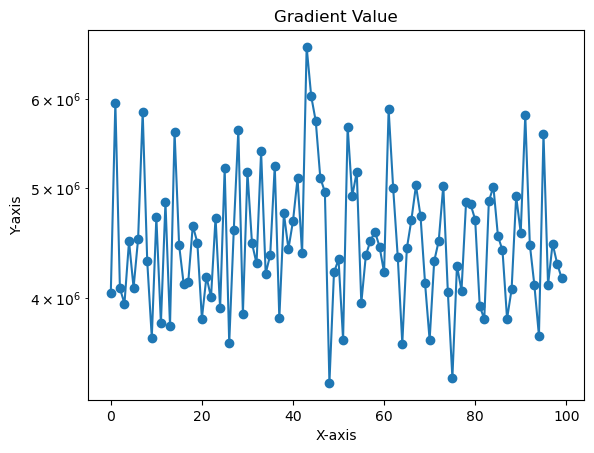

final gradient: 4163988.75


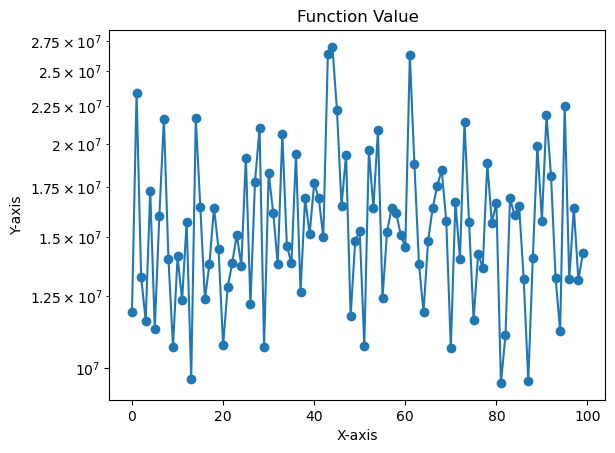


-------------------------------------Learning Rate 0.01 -----------------------------------------
Objective Function Value: 4807331.111767265
--------------------------------------------------------------BCD iteration 0 --------------------------------------------------------------
---------------------------------------------Sep 0 Factor 0 -------------------------------------------------
Iteration: 0, Separation Rank: 0, Factor Matrix: 0, Objective Function Value: 4209555.333179184
---------------------------------------------Sep 0 Factor 1 -------------------------------------------------
Iteration: 0, Separation Rank: 0, Factor Matrix: 1, Objective Function Value: 3188836.4810146284
---------------------------------------------Sep 1 Factor 0 -------------------------------------------------
Iteration: 0, Separation Rank: 1, Factor Matrix: 0, Objective Function Value: 3722319.476268053
---------------------------------------------Sep 1 Factor 1 -------------------------------------

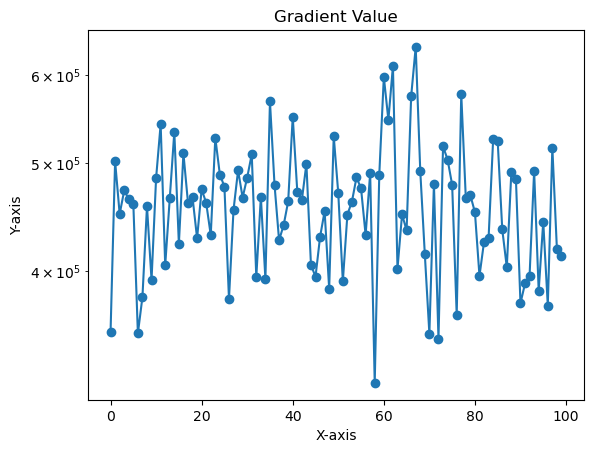

final gradient: 412631.28125


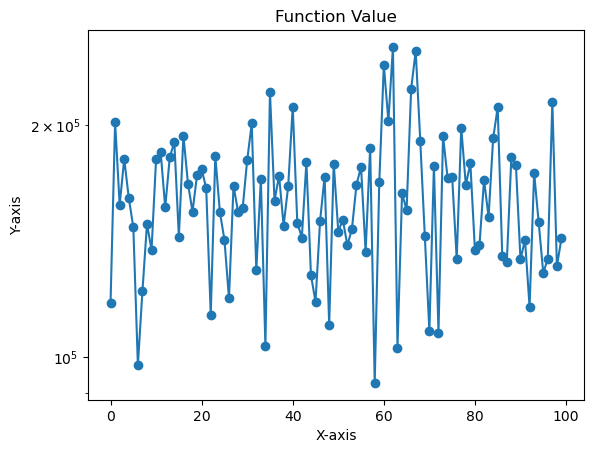


-------------------------------------Learning Rate 0.001 -----------------------------------------
Objective Function Value: 4807331.111767265
--------------------------------------------------------------BCD iteration 0 --------------------------------------------------------------
---------------------------------------------Sep 0 Factor 0 -------------------------------------------------
Iteration: 0, Separation Rank: 0, Factor Matrix: 0, Objective Function Value: 4209555.333179184
---------------------------------------------Sep 0 Factor 1 -------------------------------------------------
Iteration: 0, Separation Rank: 0, Factor Matrix: 1, Objective Function Value: 3188836.4810146284
---------------------------------------------Sep 1 Factor 0 -------------------------------------------------
Iteration: 0, Separation Rank: 1, Factor Matrix: 0, Objective Function Value: 3722319.476268053
---------------------------------------------Sep 1 Factor 1 ------------------------------------

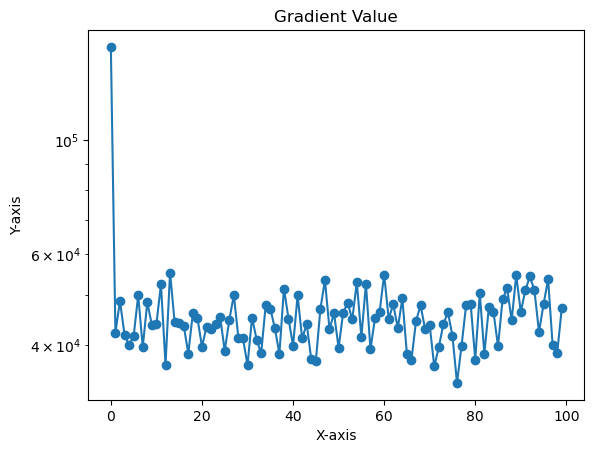

final gradient: 47149.046875


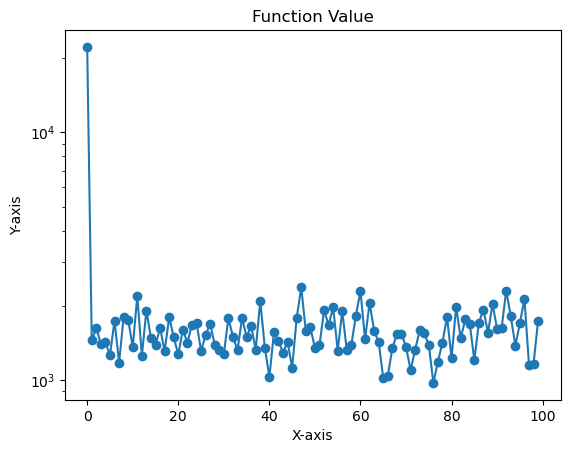


-------------------------------------Learning Rate 0.0001 -----------------------------------------
Objective Function Value: 4807331.111767265
--------------------------------------------------------------BCD iteration 0 --------------------------------------------------------------
---------------------------------------------Sep 0 Factor 0 -------------------------------------------------
Iteration: 0, Separation Rank: 0, Factor Matrix: 0, Objective Function Value: 4209555.333179184
---------------------------------------------Sep 0 Factor 1 -------------------------------------------------
Iteration: 0, Separation Rank: 0, Factor Matrix: 1, Objective Function Value: 3188836.4810146284
---------------------------------------------Sep 1 Factor 0 -------------------------------------------------
Iteration: 0, Separation Rank: 1, Factor Matrix: 0, Objective Function Value: 3722319.476268053
---------------------------------------------Sep 1 Factor 1 -----------------------------------

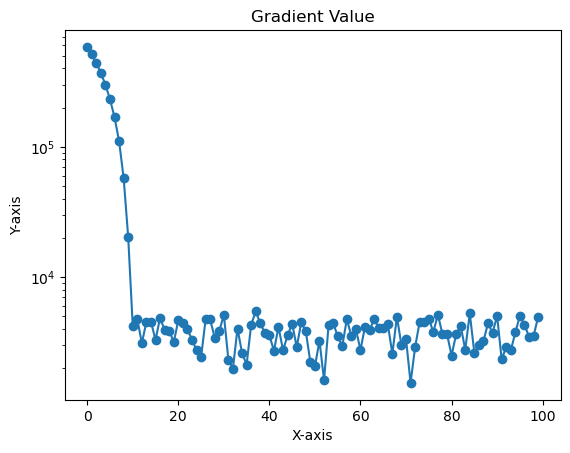

final gradient: 4908.14990234375


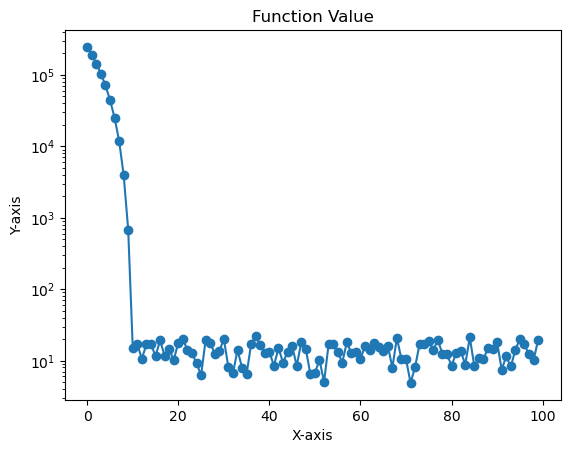


-------------------------------------Learning Rate 1e-05 -----------------------------------------
Objective Function Value: 4807331.111767265
--------------------------------------------------------------BCD iteration 0 --------------------------------------------------------------
---------------------------------------------Sep 0 Factor 0 -------------------------------------------------
Iteration: 0, Separation Rank: 0, Factor Matrix: 0, Objective Function Value: 4209555.333179184
---------------------------------------------Sep 0 Factor 1 -------------------------------------------------
Iteration: 0, Separation Rank: 0, Factor Matrix: 1, Objective Function Value: 3188836.4810146284
---------------------------------------------Sep 1 Factor 0 -------------------------------------------------
Iteration: 0, Separation Rank: 1, Factor Matrix: 0, Objective Function Value: 3722319.476268053
---------------------------------------------Sep 1 Factor 1 ------------------------------------

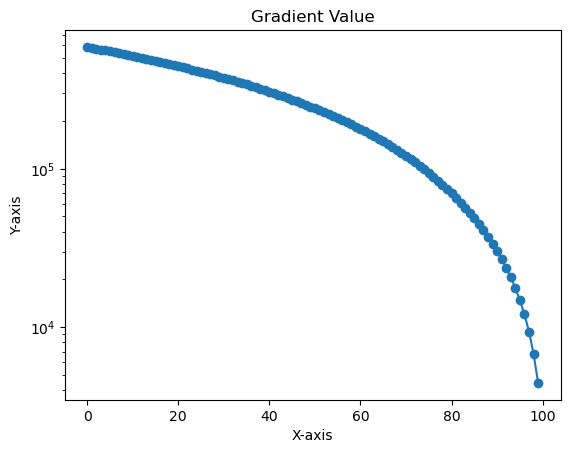

final gradient: 4440.8193359375


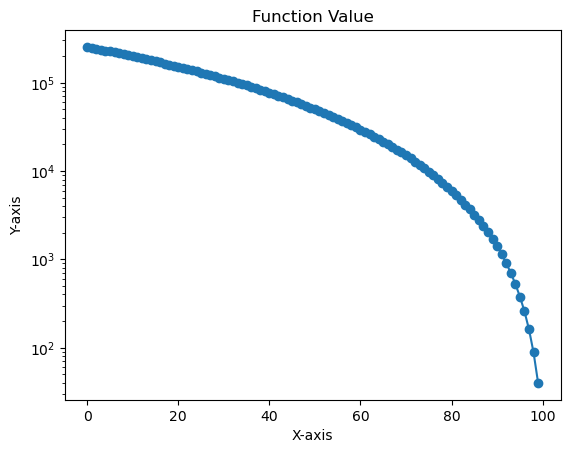

In [87]:
learning_rates = [0.1,0.01,0.001,0.0001,0.00001]


for idx,lr in enumerate (learning_rates):   
      
    try:
      print('')
      print('-------------------------------------Learning Rate',lr,'-----------------------------------------')
      lsr_tensor_SGD = copy.deepcopy(lsr_tensor_initializer)
      learning_rate = lr
      epochs = 100
      batch_size = 64

      momentum = 0
      nesterov = True
      decay_factor = 0
      hypers = {'max_iter': 1, 'threshold': 1e-4, 'ranks': tuple(tensor_mode_ranks), 'separation_rank': separation_rank,'learning_rate':learning_rate,'epochs':epochs,'batch_size': batch_size, 'momentum':momentum, 'nesterov': nesterov, 'decay_factor': decay_factor}

      normalized_estimation_error_SGD, test_nmse_loss_SGD, test_R2_loss_SGD, test_correlation_SGD, objective_function_values_SGD,gradient_values_SGD,iterate_differences_SGD,epoch_level_gradients_SGD,epoch_level_function,tensor_iteration_SGD,factor_core_iterate_SGD = train_test_sgd(X_train, Y_train, X_test, Y_test, lambda1, hypers, Y_train_mean,lsr_tensor_SGD,B_tensored,intercept= False)

    
      #Get current time and store in variable
      formatted_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
      max_iter = hypers['max_iter']
      pkl_file = f"/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression_All_Data/Platforms for Experments/Data/Experiments_Isolating_Sub_Problems/Final lr search/After Indentifinig Batch Size Issue/Gradient Descent/SGD_learning_rate_{learning_rate}_batch_size_{batch_size}_decay_{decay_factor}_intercept5_,ExecutionTime{formatted_time}, n_train_{n_train},n_test_{n_test}, tensor_dimensions:{tensor_dimensions}, tensor_mode_= ranks:{tensor_mode_ranks}, separation_rank:{separation_rank}, max_iter={max_iter}.pkl"

      #with open(pkl_file, "wb") as file:
      #  dill.dump((lsr_tensor_SGD,lambda1, normalized_estimation_error_SGD, test_nmse_loss_SGD, test_R2_loss_SGD, test_correlation_SGD, objective_function_values_SGD,gradient_values_SGD, iterate_differences_SGD,epoch_level_gradients_SGD,epoch_level_function,tensor_iteration_SGD,factor_core_iterate_SGD), file)


      print("Error Report on Testing _ With best Lambda")
      print("SGD_Alpha chosen for model: ", lambda1)
      print("SGD_Test Normalized Estimation Error: ", normalized_estimation_error_SGD)
      print("SGD_Test NMSE Loss: ", test_nmse_loss_SGD)
      print("SGD_Test R2 Loss: ", test_R2_loss_SGD)
      print("SGD_Test Correlation: ", test_correlation_SGD)
      print("Objective Function Values", objective_function_values_SGD[0,1,2])

      # Looking at the  variation of function values within a BCD iteration

      import matplotlib.pyplot as plt

      # Create a line plot
      plt.plot(epoch_level_gradients_SGD[0,1,2,:], marker='o')

      # Add title and labels
      plt.title('Gradient Value')
      plt.xlabel('X-axis')
      plt.yscale('log')
      plt.ylabel('Y-axis')

      plt.show()

      print(f'final gradient: {epoch_level_gradients_SGD[0,1,2,-1]}')
      # fucnion value

      # Create a line plot
      plt.plot(epoch_level_function[0,1,2,:], marker='o')

      # Add title and labels
      plt.title('Function Value')
      plt.xlabel('X-axis')
      plt.yscale('log') 
      plt.ylabel('Y-axis')

      plt.show()

    except Exception as e:
      print(f"An error occurred for learning rate {lr}: {e}")


In [59]:
print(G1)
print('Norm:', np.linalg.norm(G1,'fro'))
print('----------------')
print(lsr_tensor_SGD.core_tensor)
print('Norm:', np.linalg.norm(lsr_tensor_SGD.core_tensor,'fro'))

[[-0.34503602  0.48104816 -0.26876711  0.30533446]
 [-0.14360852 -0.12148134 -0.14583721 -0.15483982]
 [-0.04785435  0.29882323 -0.05810391  0.18266948]
 [ 0.01659465 -0.04146101 -0.52261706  0.0006165 ]]
Norm: 0.9999999999999999
----------------
[[-0.3448664   0.48083812 -0.26867405  0.30512166]
 [-0.14347233 -0.12130611 -0.14571218 -0.15479206]
 [-0.04788998  0.29863238 -0.05816678  0.18255568]
 [ 0.01652079 -0.04142132 -0.52234757  0.00061136]]
Norm: 0.9994678


#### Second Level


-------------------------------------Learning Rate 1.5e-06 -----------------------------------------
Objective Function Value: 22200.018682486334
--------------------------------------------------------------BCD iteration 0 --------------------------------------------------------------
---------------------------------------------Sep 0 Factor 0 -------------------------------------------------
Iteration: 0, Separation Rank: 0, Factor Matrix: 0, Objective Function Value: 22200.018682486334
---------------------------------------------Sep 0 Factor 1 -------------------------------------------------
Iteration: 0, Separation Rank: 0, Factor Matrix: 1, Objective Function Value: 22200.018682486334
---------------------------------------------Sep 1 Factor 0 -------------------------------------------------
Iteration: 0, Separation Rank: 1, Factor Matrix: 0, Objective Function Value: 22200.018682486334
---------------------------------------------Sep 1 Factor 1 -------------------------------

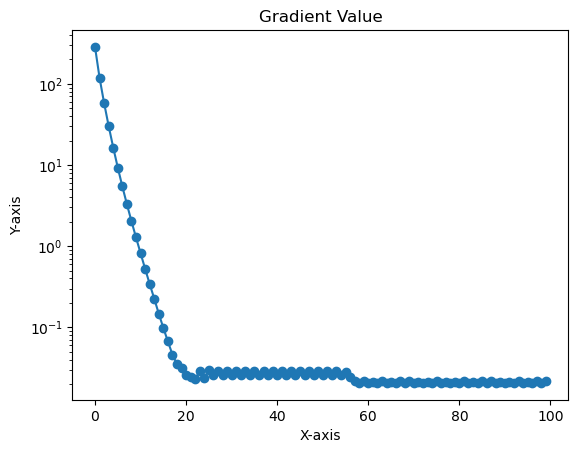

final gradient: 0.02164187654852867


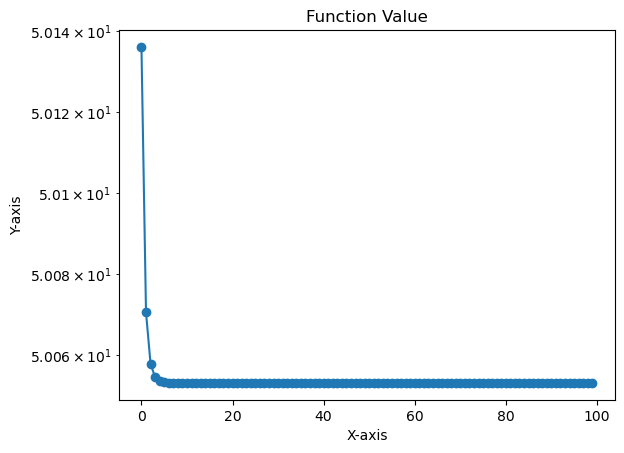

In [53]:
learning_rates = [0.0000015]
 

for idx,lr in enumerate (learning_rates):   
      
      print('')
      print('-------------------------------------Learning Rate',lr,'-----------------------------------------')
      lsr_tensor_SGD_2 = copy.deepcopy(factor_core_iterate_SGD[-1])
      learning_rate = lr
      epochs = 100
      batch_size = 650

      momentum = 0
      nesterov = False
      decay_factor = 0
      hypers = {'max_iter': 1, 'threshold': 1e-4, 'ranks': tuple(tensor_mode_ranks), 'separation_rank': separation_rank,'learning_rate':learning_rate,'epochs':epochs,'batch_size': batch_size, 'momentum':momentum, 'nesterov': nesterov, 'decay_factor': decay_factor}

      normalized_estimation_error_SGD_2, test_nmse_loss_SGD_2, test_R2_loss_SGD_2, test_correlation_SGD_2, objective_function_values_SGD_2,gradient_values_SGD_2,iterate_differences_SGD_2,epoch_level_gradients_SGD_2,epoch_level_function_2,tensor_iteration_SGD_2,factor_core_iterate_SGD_2 = train_test_sgd(X_train, Y_train, X_test, Y_test, lambda1, hypers, Y_train_mean,lsr_tensor_SGD_2,B_tensored,intercept= False, Initializer = lsr_tensor_SGD_2.core_tensor)

    
      #Get current time and store in variable
      formatted_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
      max_iter = hypers['max_iter']
      pkl_file = f"/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression_All_Data/Platforms for Experments/Data/Experiments_Isolating_Sub_Problems/Final lr search/After Indentifinig Batch Size Issue/Gradient Descent/SGD_Level_2_SGD_Full_Batch_learning_rate_{learning_rate}_decay_{decay_factor}_intercept5_,ExecutionTime{formatted_time}, n_train_{n_train},n_test_{n_test}, tensor_dimensions:{tensor_dimensions}, tensor_mode_= ranks:{tensor_mode_ranks}, separation_rank:{separation_rank}, max_iter={max_iter}.pkl"

      with open(pkl_file, "wb") as file:
        dill.dump((lsr_tensor_SGD_2,lambda1, normalized_estimation_error_SGD_2, test_nmse_loss_SGD_2, test_R2_loss_SGD_2, test_correlation_SGD_2, objective_function_values_SGD_2,gradient_values_SGD_2,iterate_differences_SGD_2,epoch_level_gradients_SGD_2,epoch_level_function_2,tensor_iteration_SGD_2,factor_core_iterate_SGD_2), file)


      print("Error Report on Testing _ With best Lambda")
      print("SGD_Alpha chosen for model: ", lambda1)
      print("SGD_Test Normalized Estimation Error: ", normalized_estimation_error_SGD_2)
      print("SGD_Test NMSE Loss: ", test_nmse_loss_SGD_2)
      print("SGD_Test R2 Loss: ", test_R2_loss_SGD_2)
      print("SGD_Test Correlation: ", test_correlation_SGD_2)
      print("Objective Function Values", objective_function_values_SGD_2[0,1,2])

      # Looking at the  variation of function values within a BCD iteration

      import matplotlib.pyplot as plt

      # Create a line plot
      plt.plot(epoch_level_gradients_SGD_2[0,1,2,:], marker='o')

      # Add title and labels
      plt.title('Gradient Value')
      plt.xlabel('X-axis')
      plt.yscale('log')
      plt.ylabel('Y-axis')

      plt.show()

      print(f'final gradient: {epoch_level_gradients_SGD_2[0,1,2,-1]}')
      # fucnion value

      # Create a line plot
      plt.plot(epoch_level_function_2[0,1,2,:], marker='o')

      # Add title and labels
      plt.title('Function Value')
      plt.xlabel('X-axis')
      plt.yscale('log') 
      plt.ylabel('Y-axis')

      plt.show()


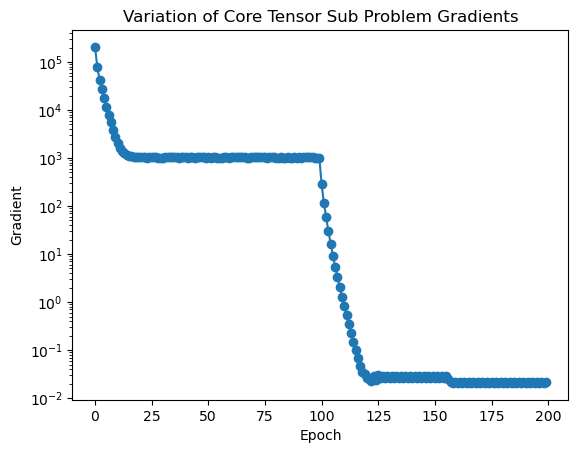

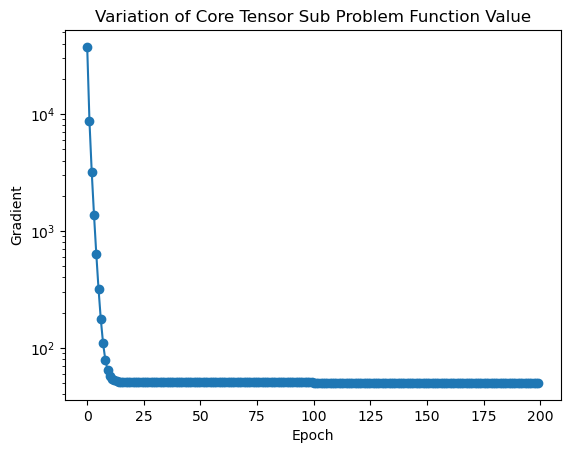

In [54]:
#gradient of core tensor
gradient_set_1 = epoch_level_gradients_SGD[0,1,-1]
gradient_set_2 = epoch_level_gradients_SGD_2[0,1,-1]

#concatanating the gradients 
concatanated_gradients = np.concatenate((gradient_set_1,gradient_set_2))

# Plotting the concatenated array
plt.plot(concatanated_gradients, marker = 'o')
plt.title('Variation of Core Tensor Sub Problem Gradients')
plt.xlabel('Epoch')
plt.ylabel('Gradient')
plt.yscale('log')
plt.show()

#gradient of core tensor
function_set_1 = epoch_level_function[0,1,-1]
function_set_2 = epoch_level_function_2[0,1,-1]

#concatanating the gradients 
concatanated_gradients = np.concatenate((function_set_1,function_set_2))

# Plotting the concatenated array
plt.plot(concatanated_gradients, marker = 'o')
plt.title('Variation of Core Tensor Sub Problem Function Value')
plt.xlabel('Epoch')
plt.ylabel('Gradient')
plt.yscale('log')
plt.show()




In [ ]:
# need to change the batch size of the core tensor sub problem from 64 - batch_size